# DEEP LEARNING PROJECT
#Name: GRASSI RICCARDO
##Matr: 1045404

# Blind source separation
The purpose of the project is to separate an image obtained as a sum of a two images into its components. 

The two images img1 and img2 summed together come from different dataset: mnist and fashion_mnist, respectively.

No preprocessing is allowed. The network takes in input the sum img1+img2 and returns the predicted components hat_img1 and hat_img2. 

The metric used to evaluate the project is the mean squared error between predicted and ground truth images.


In [1]:
import tensorflow as tf
import tensorflow.keras.backend as K
import os
import numpy as np

from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist, fashion_mnist
from tensorflow import keras as ks
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from tensorflow.data import Dataset
from matplotlib import pyplot as plt

Here we load the two datasets, mnist and fashion mnist (both in grayscale).

For simplicity, the samples are padded to dimension (32,32).

In [2]:
(mnist_x_train, mnist_y_train), (mnist_x_test, mnist_y_test) = mnist.load_data()
print(np.shape(mnist_x_train))
(fashion_mnist_x_train, fashion_mnist_y_train), (fashion_mnist_x_test, fashion_mnist_y_test) = fashion_mnist.load_data()
#normnalize in and pad
mnist_x_train = np.pad(mnist_x_train,((0,0),(2,2),(2,2)))/255.
print(np.shape(mnist_x_train))
mnist_x_test = np.pad(mnist_x_test,((0,0),(2,2),(2,2)))/255.
fashion_mnist_x_train = np.pad(fashion_mnist_x_train,((0,0),(2,2),(2,2)))/255.
fashion_mnist_x_test = np.pad(fashion_mnist_x_test,((0,0),(2,2),(2,2)))/255.

11501568/11490434 [==============================] - 0s 0us/step
(60000, 28, 28)
4431872/4422102 [==============================] - 0s 0us/step
(60000, 32, 32)


In [ ]:
print(np.shape(mnist_x_train))

(60000, 32, 32)


## Data generator
Here there is a data generator to create randomly an imagine from the fusion of two images from two different datasets.




In [3]:
def datagenerator(x1,x2,batchsize):
    n1 = x1.shape[0]
    n2 = x2.shape[0]
    while True:
        num1 = np.random.randint(0, n1, batchsize)
        num2 = np.random.randint(0, n2, batchsize)

        x_data = (x1[num1] + x2[num2]) / 2.0
        y_data = np.concatenate((x1[num1], x2[num2]), axis=2)

        yield x_data, y_data 

Here we define two generators, one for training and one for testing. You may possibly add an addition generator for validation, further splitting the dataset.

In [4]:
train_generator = datagenerator(mnist_x_train,fashion_mnist_x_train,1)
test_generator = datagenerator(mnist_x_test,fashion_mnist_x_test,1)

Let us look at some input-output pairs

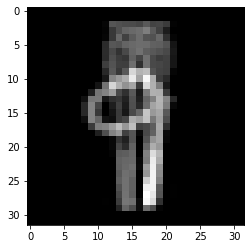

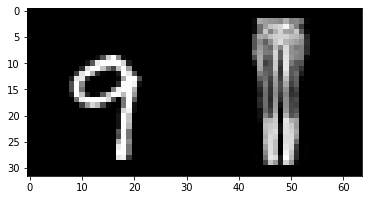

In [5]:
x, y = next(train_generator)
plt.imshow(x[0],cmap='gray', interpolation='nearest')
plt.show()
plt.imshow(y[0], cmap='gray', interpolation='nearest')
plt.show()

## UNET architecture
UNet Architecture has 3 parts:

* Downsampling Path
* Bottleneck
* Upsampling Path

##Downsampling Path
It consists of two 3x3 convolutions, each followed by a rectified linear unit (ReLU) and a 2x2 max pooling operation with stride 2 for downsampling. 2 downsampling step have been implemented.
At each downsampling step the number of feature channels are doubled.

##Upsampling Path
Every step in the upsampling path consists of a transposed convolution layer with a 2x2 convolution kernel(“up-convolution”), a concatenation with the correspondingly feature map from the downsampling path, and four 3x3 convolutions, each followed by a ReLU. At each upsampling step the number of feature channels are halved.

##Bottleneck
The central layer is composed by 2 convolutions, each followed by a ReLu.

##Depthwise Layer
I've added a depthwise layer before the final layer in order to keep channels separated and I've noticed that with the creation of that layer there is a large decrease in the Mse.

##Final Layer
At the final layer a 1x1 convolution is used to map each feature vector to the desired number of classes. After that, the 2 output channel are stored into 2 different variables and are linked together.

Finally the net has totally 27 layers and 3 684 214 params.







In [6]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3):
    # first layer
    x = ks.layers.Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size), padding = 'same', activation='relu')(input_tensor)
    # second layer
    x = ks.layers.Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size), padding = 'same', activation='relu')(x)
    return x

def conv2d_block_up(input_tensor, n_filters, kernel_size = 3):
    # first layer
    x = ks.layers.Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size), padding = 'same', activation='relu')(input_tensor)
    # second layer
    x = ks.layers.Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size), padding = 'same', activation='relu')(x)
    # third layer
    x = ks.layers.Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size), padding = 'same', activation='relu')(x)
    # fourth layer
    x = ks.layers.Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size), padding = 'same', activation='relu')(x)
    return x

In [7]:
def build_net():
    
    # DOWN
    x = ks.layers.Input(shape=(32,32))
    x = ks.layers.Reshape((*(32,32), 1))(x)
    down_layers = []
    h = x
   
    # block 32 conv
    h = conv2d_block(h,32)
    down_layers.append(h)
    #max pool
    h = ks.layers.MaxPool2D(pool_size=(2, 2),padding='same')(h)
   

    # block 64 conv
    h = conv2d_block(h,64)
    down_layers.append(h)
    #max pool
    h = ks.layers.MaxPool2D(pool_size=(2, 2),padding='same')(h)
    

    # central convolutional block
    h = conv2d_block(h,128)

    #UPSAMPLING

    #up
    up = ks.layers.Conv2DTranspose(filters=256, kernel_size=(2, 2), strides=2)(h)            
    down = down_layers.pop()
    h = ks.layers.concatenate([down, up])
    h = conv2d_block_up(h,256)

    #up
    up = ks.layers.Conv2DTranspose(filters=128, kernel_size=(2, 2), strides=2)(h)            
    down = down_layers.pop()
    h = ks.layers.concatenate([down, up])
    h = conv2d_block_up(h,128)

    # Output
    h = ks.layers.Conv2D(filters=2, kernel_size=(1, 1))(h)
    h = ks.layers.DepthwiseConv2D(kernel_size=(3,3),padding='same')(h)
    y1 = h[:, :, :, 0]
    y2 = h[:, :, :, 1]

    #concatenation of the images 
    h = tf.concat([y1, y2], axis=2)
    y = ks.layers.Reshape((32, 64))(h)

    return ks.models.Model(x, y)

In [8]:
unet_model = build_net()
optimizer = ks.optimizers.Adam(learning_rate=1e-3)
unet_model.compile(optimizer=optimizer, loss='mse', metrics=['mse'])

print(unet_model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 32, 32, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 32)   320         ['input_2[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 32, 32, 32)   9248        ['conv2d[1][0]']                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 16, 16, 32)   0           ['conv2d_1[1][0]']               
                                                                                              

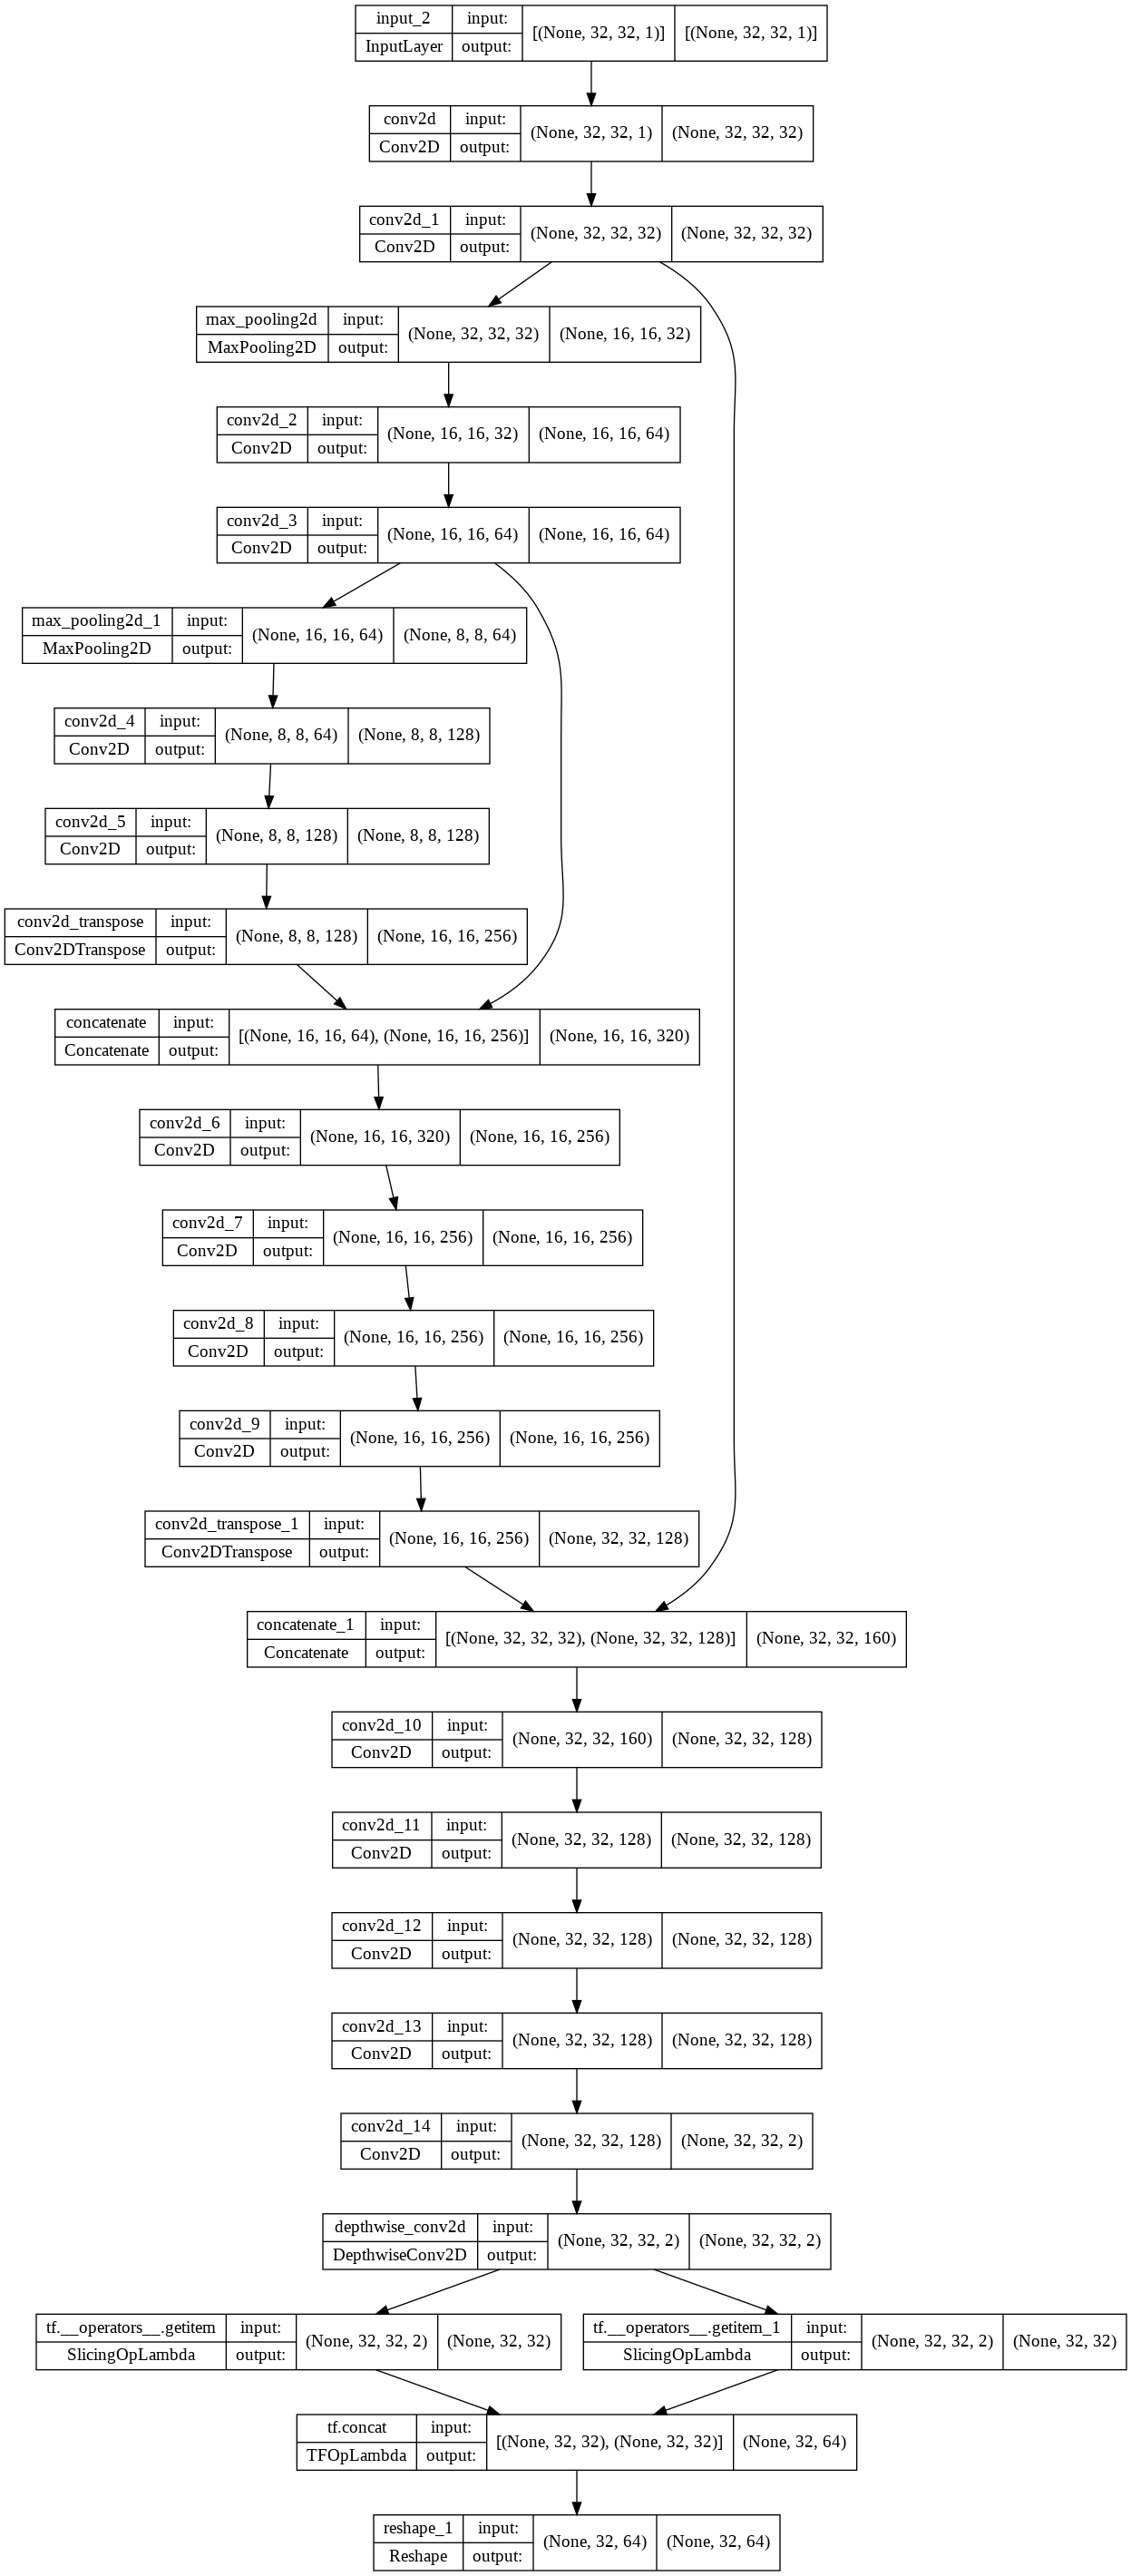

In [ ]:
ks.utils.plot_model(model=unet_model, to_file='unet.png', show_shapes=True)

## Callbacks
Callbacks provide a way to execute code and interact with the training model process automatically. I've decided to use 2 main callbacks:
* **early stopping callback**: used to stop the training of the net when the loss does not decrease. I've set patience parameter to 30, so after 30 epochs of non improvements this callback is activated. I have chosen an high number in order to let the model train for the largest number of epochs.
* **reduce on plateau callback**: reduce learning rate when a metric has stopped improving. I've set patience parameter to 10, so after 10 epochs of stable loss this callback is activated and the learning rate is decreased in an auomatic way.


In [10]:
working_dir = 'unet'
epochs = 100
batch_size = 32 #32
metric = 'mse'
monitor = f'val_{metric}'


## CALLBACK
early_stopping_callback = ks.callbacks.EarlyStopping(monitor=monitor, patience=30, verbose=1, mode='auto', restore_best_weights=True)
reduce_on_plateau_callback = ks.callbacks.ReduceLROnPlateau(monitor='loss', min_lr=1e-5, factor=0.5, patience=10, verbose=1, mode='min')

# ModelCheckpoint
checkpoint_dir = os.path.join(working_dir, 'ckpt')
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)
checkpoint_filepath = os.path.join(checkpoint_dir, 'weights_{epoch:02d}-{val_loss:.2f}.hdf5')
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor=monitor,
    mode='min',
    save_weights_only=True,
    save_best_only=True)

callbacks = [
    early_stopping_callback,
    reduce_on_plateau_callback,
    model_checkpoint_callback,
]




## Creation of train and validation set 

In [11]:
mnist_train, mnist_val = train_test_split(mnist_x_train, test_size=0.1)
fashion_mnist_train, fashion_mnist_val = train_test_split(fashion_mnist_x_train, test_size=0.1)


train_data = datagenerator(mnist_train, fashion_mnist_train, batch_size)
val_data = datagenerator(mnist_val, fashion_mnist_val, batch_size)

## Fit the model


In [ ]:
steps = 5000
val_steps = 500

history = unet_model.fit(train_data, steps_per_epoch=steps,
                    validation_data=val_data, validation_steps=val_steps,
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks= callbacks)


Epoch 1/100
5000/5000 [==============================] - 145s 26ms/step - loss: 0.0032 - mse: 0.0032 - val_loss: 0.0014 - val_mse: 0.0014 - lr: 0.0010
Epoch 2/100
5000/5000 [==============================] - 131s 26ms/step - loss: 0.0012 - mse: 0.0012 - val_loss: 9.5873e-04 - val_mse: 9.5873e-04 - lr: 0.0010
Epoch 3/100
5000/5000 [==============================] - 130s 26ms/step - loss: 9.5195e-04 - mse: 9.5195e-04 - val_loss: 8.1370e-04 - val_mse: 8.1370e-04 - lr: 0.0010
Epoch 4/100
5000/5000 [==============================] - 130s 26ms/step - loss: 8.8337e-04 - mse: 8.8337e-04 - val_loss: 7.9661e-04 - val_mse: 7.9661e-04 - lr: 0.0010
Epoch 5/100
5000/5000 [==============================] - 130s 26ms/step - loss: 7.7198e-04 - mse: 7.7198e-04 - val_loss: 6.9973e-04 - val_mse: 6.9973e-04 - lr: 0.0010
Epoch 6/100
5000/5000 [==============================] - 130s 26ms/step - loss: 7.3048e-04 - mse: 7.3048e-04 - val_loss: 6.6180e-04 - val_mse: 6.6180e-04 - lr: 0.0010
Epoch 7/100
5000/5000 

## History of the error

In [ ]:
def display_history(history):
    mse_training = history.history['mse']
    mse_val = history.history['val_mse']

    # Visualize the behavior of the loss
    plt.plot(mse_training)
    plt.plot(mse_val)
    plt.grid()
    plt.title('Mse during training')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Validation'])
    plt.show()

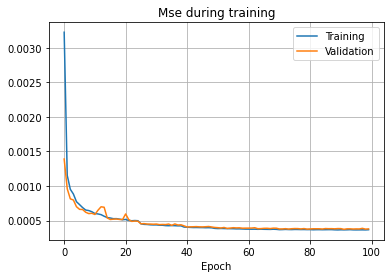

In [ ]:
display_history(history)

In [ ]:
#unet_model.save_weights('best_weights.hdf5')

## Evaluation of the model
In order to evaluate the model I restore the results of a previous fitting which allows me to get the best Mse error.


In [20]:
test_generator = datagenerator(mnist_x_test, fashion_mnist_x_test,20000)
#restoring of the previous model
unet_model.load_weights('best_weights.hdf5')

optimizer = ks.optimizers.Adam(learning_rate=1e-3)
unet_model.compile(optimizer=optimizer, loss='mse', metrics=['mse'])

error_list = []
for i in  range(10):
    x_test,y_test = next(test_generator)
    y_pred = unet_model.predict(x_test)
    m = ks.metrics.MeanSquaredError()
    m.update_state(y_test.astype('float32'),  y_pred.astype('float32'))
    mse = m.result().numpy()
    error_list.append(mse)

## Results
This show the best results of the model, as we can see the standard deviation is very low and the final mean squared error obtained is the following:

In [21]:
print("Mean of MSE: ",np.mean(error_list))
print("Std of MSE: ",np.std(error_list))
print("Minimum MSE obtained: ",np.min(error_list))

Mean of MSE:  0.00036597377
Std of MSE:  2.705041e-06
Minimum MSE obtained:  0.00036076957


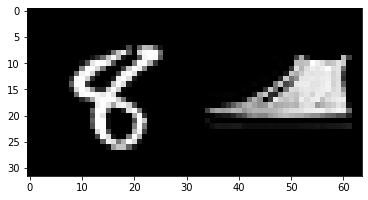

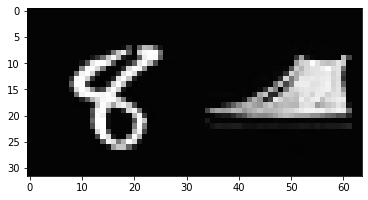

In [ ]:
plt.imshow(y_test[0], cmap='gray', interpolation='nearest')
plt.show()
plt.imshow(y_pred[0], cmap='gray', interpolation='nearest')
plt.show()